<a href="https://colab.research.google.com/github/trueTRYtre3/Dog-Breed-Identification/blob/master/dog_spotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class Dog Breed Classification

This notebook builds a multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of dog given an image of a dog.

## 2. Data 

The data is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is based on prediction probabilities for each dog breed of each test image.

## 4. Features

Data composed with:
* Images (Unstructued Data)
* There are 120 breeds of Dogs (120 different classes)
* 10,000+ images in training set (images have labels)
* 10,000+ images in test set (images have no labels)

In [0]:
# unzip data into google drive
#!unzip "drive/My Drive/dog-spotter/dog-breed-identification.zip" -d "drive/My Drive/dog-spotter/"

### Get our Workspace Ready

In [2]:
# Import TensorFlow
import tensorflow as tf
import tensorflow_hub as hub

# Check for GPU availability
print('GPU', 'available' if tf.config.list_physical_devices('GPU') else 'not available') 

GPU available


In [0]:
#print('TF version: ', tf.__version__)
#print('Hub Version: ', hub.__version__)

### Getting Our Data Ready (turning it into Tensors)

With all machine learning models, our data has to be in numerical format.  Turning our images into tensors (numerical represenation)

In [4]:
# Check labels of data
import pandas as pd
label_data = pd.read_csv('drive/My Drive/dog-spotter/labels.csv')
print(label_data.describe())
print(label_data.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     74f4fa04d8752fff46c4d10fafe3e072  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


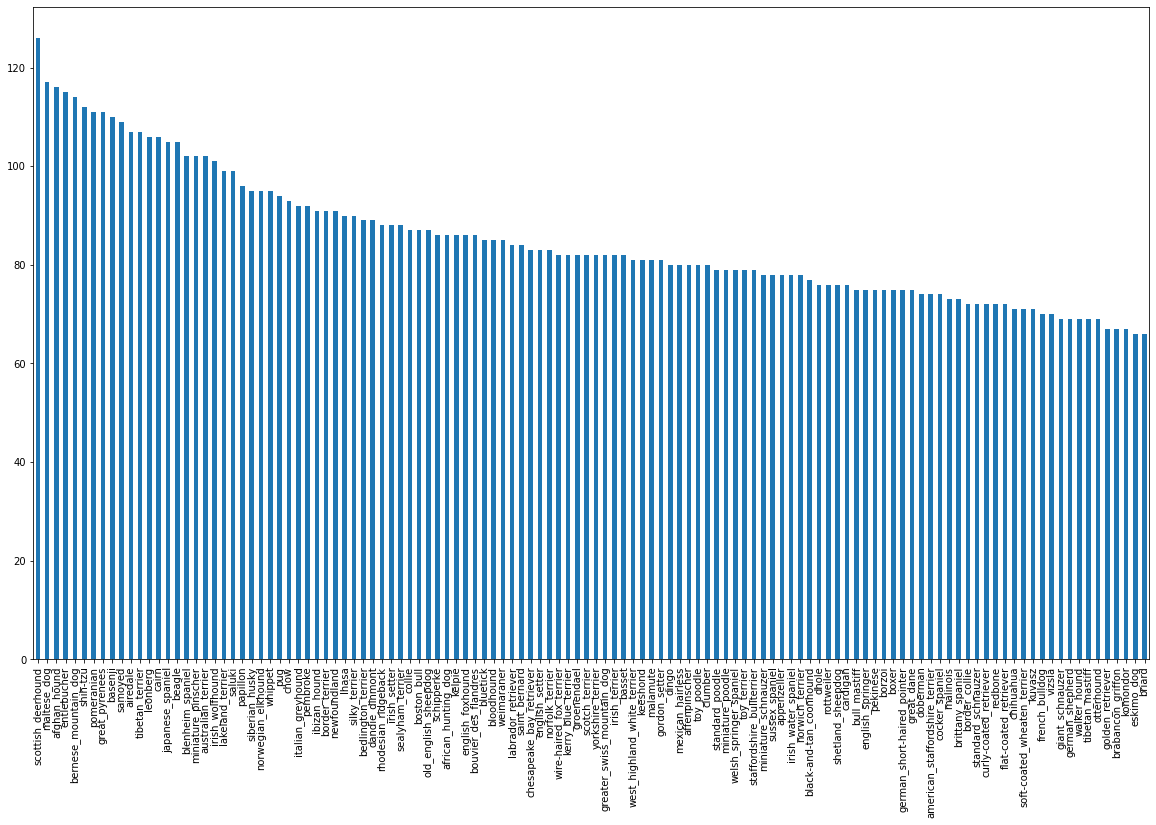

In [5]:
# How many images of each breed)
label_data.breed.value_counts().plot(kind = 'bar', figsize = (20,12))

In [6]:
label_data.breed.value_counts().median()

82.0

In [7]:
label_data.breed.value_counts().min()

66

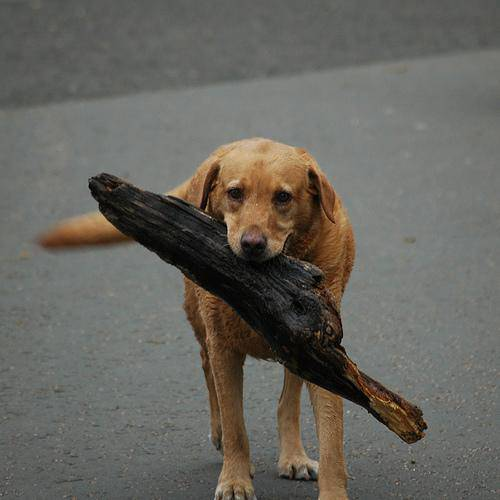

In [8]:
# Viewing an image
from IPython.display import Image
Image("drive/My Drive/dog-spotter/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting Images and their Labels

Create list of all our image filenames

In [9]:
label_data.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
# Create pathnames from Image ID
filenames = ["drive/My Drive/dog-spotter/train/" + fname + ".jpg" for fname in label_data['id']]

In [11]:
filenames[:10]

['drive/My Drive/dog-spotter/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog-spotter/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog-spotter/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog-spotter/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog-spotter/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog-spotter/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog-spotter/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog-spotter/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog-spotter/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog-spotter/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# Check whether filenames matches number of actual image files
import os
if len(os.listdir('drive/My Drive/dog-spotter/train')) == len(filenames):
  print('Filenames is equal to actual amount of files.')
else:
  print('Filenames do not match length of actual files. Check target directory!')

Filenames is equal to actual amount of files.


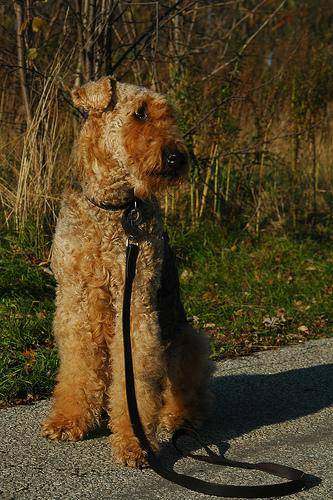

In [13]:
Image(filenames[5000])

In [14]:
label_data.breed[5000]

'airedale'

With training image filepaths in a list, let's prepare our labels

In [0]:
import numpy as np
labels = label_data['breed'].to_numpy()
#labels = np.array(labels)

In [16]:
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [17]:
len(labels)

10222

In [18]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames): print('Number of labels matches number of filenames.')
else: print('Number of labels does not match number of filenames, check directory.')

Number of labels matches number of filenames.


In [19]:
# Find unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [20]:
len(unique_breeds)

120

In [21]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [22]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
len(boolean_labels)

10222

In [24]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [25]:
print(labels[5])
print(boolean_labels[5].astype(int))

bedlington_terrier
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating a Validation Set

In [0]:
# Create X and y variables 
X = filenames
y = boolean_labels

In [0]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: 'slider', min: 1000, max: 10000, step: 1000}

In [0]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

# Split train and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size = 0.2, random_state = 42)

In [29]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocessing Images (turning images into Tensors)

In [30]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [31]:
image.max()

255

In [32]:
# turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

This shows us what an image looks like as a Tensor. Let's create a function to preprocess them

In [0]:
# Define Image size
IMG_SIZE = 224

# Create a function for preprocessing images
def preprocess_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image and turns it into a Tensor
  """

  # Read image file 
  image = tf.io.read_file(image_path)
  # Turn jpeg image into numerical Tensors with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels = 3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size = [img_size, img_size])

  return image

### Turning Data into Batches

Batch size of 32 images.

In order to use Tensorflow effectively, we need data in the form of Tensor tuples: `(image, label)` 

In [0]:
# Create simple function to create tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes image file path and label and preprocesses it then 
  returns a tuple of (image, label) 
  """
  image = preprocess_image(image_path)
  return image, label

In [0]:
# Define the batch size, let's start with 32
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles data if its training data but doesn't shuffle if its validation data.
  Accepts test data as input (no labels)
  """
  # if the data is a test dataset, it has no labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(preprocess_image).batch(batch_size)
    return data_batch

  # if the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # (filepaths, labels)
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  # this will be training batch, we want to shuffle this set
  else:
    print('Creating training data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # (filepaths, labels)
    # Shuffle full length of data before preproccessing it so that it can shuffle quicker
    data = data.shuffle(buffer_size = len(X))
    data = data.map(get_image_label) # Create (image, label) tuple (also turns image path into preprocessed image)
    data_batch = data.batch(batch_size)
  
  return data_batch
  


In [36]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches...
Creating validation data batches...


In [0]:
# Check out different attributes of data batches
#train_data.element_spec, valid_data.element_spec 

## Visualizing Data Batches

In [0]:
import matplotlib.pyplot as plt

# Function to view images in a data batch
def show_images(images, labels):
  """
  Shows plot of images and associated labels in a data batch
  """

  plt.figure(figsize = (14,10))
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis('off')

In [0]:
train_images, train_labels = next(train_data.as_numpy_iterator())

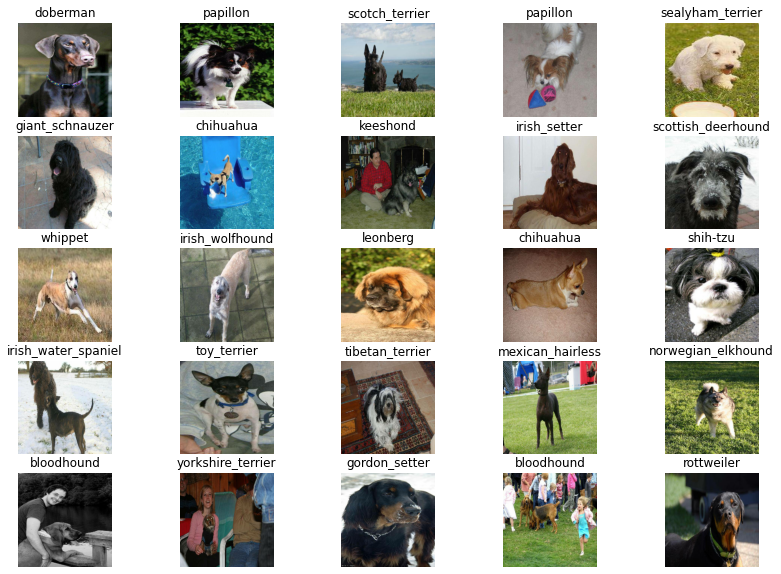

In [40]:
show_images(train_images, train_labels)

## Building a Model

Before building a model, we need to define a few things
* Input shape (image shape in the form of Tensors)
* Output shape (image labels in form of Tensors)
* URL of the model we want to use from TensorFlow Hub: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [0]:
# Setup input shape of the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # input shape of image [batch, height, width, color channels]

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Putting input, output, and model together into a Keras (sequential) deep learning model.


In [0]:
# Create a function which builds a keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print('Building model with: ', MODEL_URL)

  # Setup model layers
  model = tf.keras.Sequential([
                      hub.KerasLayer(model_url), # Layer 1, input layer
                      tf.keras.layers.Dense(units=output_shape, activation = 'softmax'), # Layer 2, output layer
  ])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )

  # Build the model
  model.build(input_shape)

  return model

In [43]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

We'll create two Callbacks, one for Tensorboard which helps track our models progress and another for early stopping which prevents our model from training for too long.


### TensorBoard Callback

In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for storing tensorboard logs
  logdir = os.path.join("drive/My Drive/dog-spotter/logs", 
                        datetime.datetime.now().strftime('%Y%m%d-%H%M%S')) # Creates log whenever experiment is run

  return tf.keras.callbacks.TensorBoard(logdir)              

### Early Stopping Callbacks

Early Stopping helps prevent overfitting

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)

## Training a Model

Training a model on 1000 images

In [0]:
NUM_EPOCHS = 100 #@param {type: 'slider', min: 10, max: 100, step: 10}

Create function to train a model

In [0]:
# Build function to train and return trained model
def trained_model():
  """
  Given a model, trains and returns it
  """
  # Create a model
  model = create_model()

  # Create new tensorboard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit model to data passing it the callbacks we created
  model.fit(x = train_data, epochs = NUM_EPOCHS,
            validation_data = valid_data, validation_freq = 1,
            callbacks = [tensorboard, early_stopping])
  
  return model

In [49]:
# Fit model to data
model = trained_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 5s 212ms/step - loss: 4.6102 - accuracy: 0.0900 - val_loss: 3.2463 - val_accuracy: 0.3500
Epoch 2/100
25/25 [==============================] - 5s 195ms/step - loss: 1.6500 - accuracy: 0.6662 - val_loss: 2.0369 - val_accuracy: 0.5450
Epoch 3/100
25/25 [==============================] - 5s 193ms/step - loss: 0.5751 - accuracy: 0.9200 - val_loss: 1.5780 - val_accuracy: 0.6350
Epoch 4/100
25/25 [==============================] - 5s 188ms/step - loss: 0.2493 - accuracy: 0.9862 - val_loss: 1.3963 - val_accuracy: 0.6600
Epoch 5/100
25/25 [==============================] - 5s 194ms/step - loss: 0.1470 - accuracy: 0.9975 - val_loss: 1.3039 - val_accuracy: 0.6800
Epoch 6/100
25/25 [==============================] - 5s 192ms/step - loss: 0.1014 - accuracy: 0.9987 - val_loss: 1.2614 - val_accuracy: 0.6800
Epoch 7/100
25/25 [=============================

### Checking Tensorboard Logs

Tensorboard function (%tensorboard) will access logs directory that was created earlier and visualize its content

In [50]:
%tensorboard --logdir drive/My\ Drive/dog-spotter/logs

Reusing TensorBoard on port 6006 (pid 1517), started 7:21:41 ago. (Use '!kill 1517' to kill it.)

<IPython.core.display.Javascript object>

## Making and Evaluating Predictions Using a Trained Model

In [51]:
predictions = model.predict(valid_data, verbose = 1)
predictions

7/7 [==============================] - 1s 123ms/step


array([[3.69575835e-04, 4.41254597e-05, 1.31701119e-04, ...,
        7.30172178e-05, 3.79467492e-05, 2.46668491e-03],
       [3.28017888e-03, 1.95467612e-03, 6.78089773e-03, ...,
        6.76079944e-04, 4.33451496e-03, 1.38349351e-04],
       [2.05200581e-06, 2.19500416e-05, 4.52682252e-06, ...,
        5.67336656e-06, 1.72494492e-05, 3.18595965e-04],
       ...,
       [2.65445669e-06, 1.06999705e-05, 6.80755784e-06, ...,
        8.34062666e-06, 2.27694436e-05, 1.96330384e-05],
       [4.04385617e-03, 5.25007890e-05, 5.93164732e-05, ...,
        1.49625310e-04, 7.95299275e-05, 7.39087397e-03],
       [1.38402381e-03, 1.37724619e-05, 7.60648225e-04, ...,
        3.49325850e-03, 6.24884051e-05, 1.04450482e-04]], dtype=float32)

In [52]:
# Turn prediction probabilites into their respective label
def prediction_label(prediction_prob):
  """
  Turns an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_prob)]

# Get predicted label based on an array of prediction probabilites
pred_label = prediction_label(predictions[0])
pred_label

'cairn'

In [53]:
# Create a function to unbatch dataset
def unbatch_fn(data):
  """
  Takes batch dataset of (image, label) tensors and returns seperate arrays of images and labels
  """
  images = []
  labels = []

  # Loop for unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  
  return images, labels

# Unbatch validation data
val_images, val_labels = unbatch_fn(valid_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [54]:
prediction_label(val_labels[0])

'affenpinscher'

In [0]:
def plot_prediction(prediction_prob, labels, images, n = 1):
  """
  View prediction, truth label and image for given sample n
  """
  pred_prob, true_label, image = prediction_prob[n], labels[n], images[n]

  # Get the predicted label
  pred_label = prediction_label(pred_prob)

  # Change color of prediction depending on if prediction is right or wrong
  if pred_label == true_label:
    color = 'green'
  else:
    color = 'red'

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title('{} {:2.0f}% {}'.format(pred_label, np.max(pred_prob) * 100, true_label), color = color)

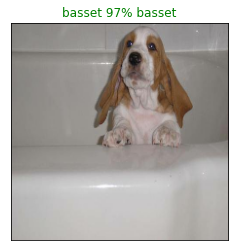

In [56]:
plot_prediction(prediction_prob= predictions, labels = val_labels, images = val_images, n = 2)

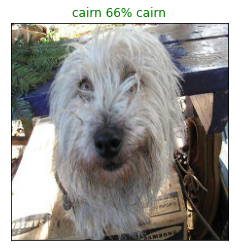

In [57]:
plot_prediction(prediction_prob = predictions, labels = val_labels, images = val_images, n = 0)

In [0]:
# Function to view top 10 predictions 
def plot_10_prediction(prediction_probabilites, labels, n = 1):
  """
  Plus the top 10 highest prediction confidences along with true labels for sample n
  """

  pred_prob, true_labels = prediction_probabilites[n], labels[n]

  # Get predicted label
  pred_label = prediction_label(pred_prob)

  # View top 10 prediction confidence indexes
  top_pred_indexes = pred_prob.argsort()[-10:][::-1] 

  # Find top 10 prediction confidence values
  top_pred_values = pred_prob[top_pred_indexes]

  # Find top 10 prediction labels
  top_pred_labels = unique_breeds[top_pred_indexes]

  # Plot
  top_plot = plt.bar(np.arange(len(top_pred_labels)), top_pred_values, color = 'grey')
  plt.xticks(np.arange(len(top_pred_labels)), labels = top_pred_labels, rotation = 'vertical')

  # Changle color of true label
  if np.isin(true_labels, top_pred_labels):
    top_plot[np.argmax(top_pred_labels == true_labels)].set_color('green')
  else:
    pass

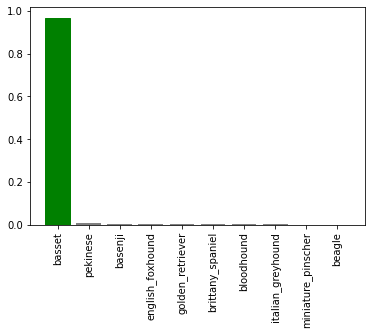

In [59]:
plot_10_prediction(prediction_probabilites = predictions, labels = val_labels, n = 2)

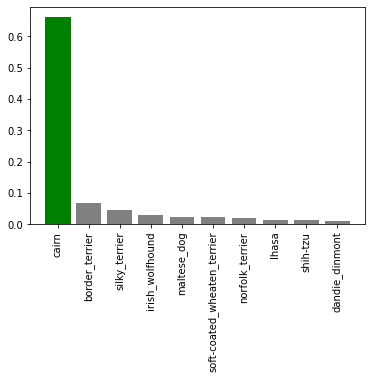

In [60]:
plot_10_prediction(prediction_probabilites=predictions, labels = val_labels, n = 0)

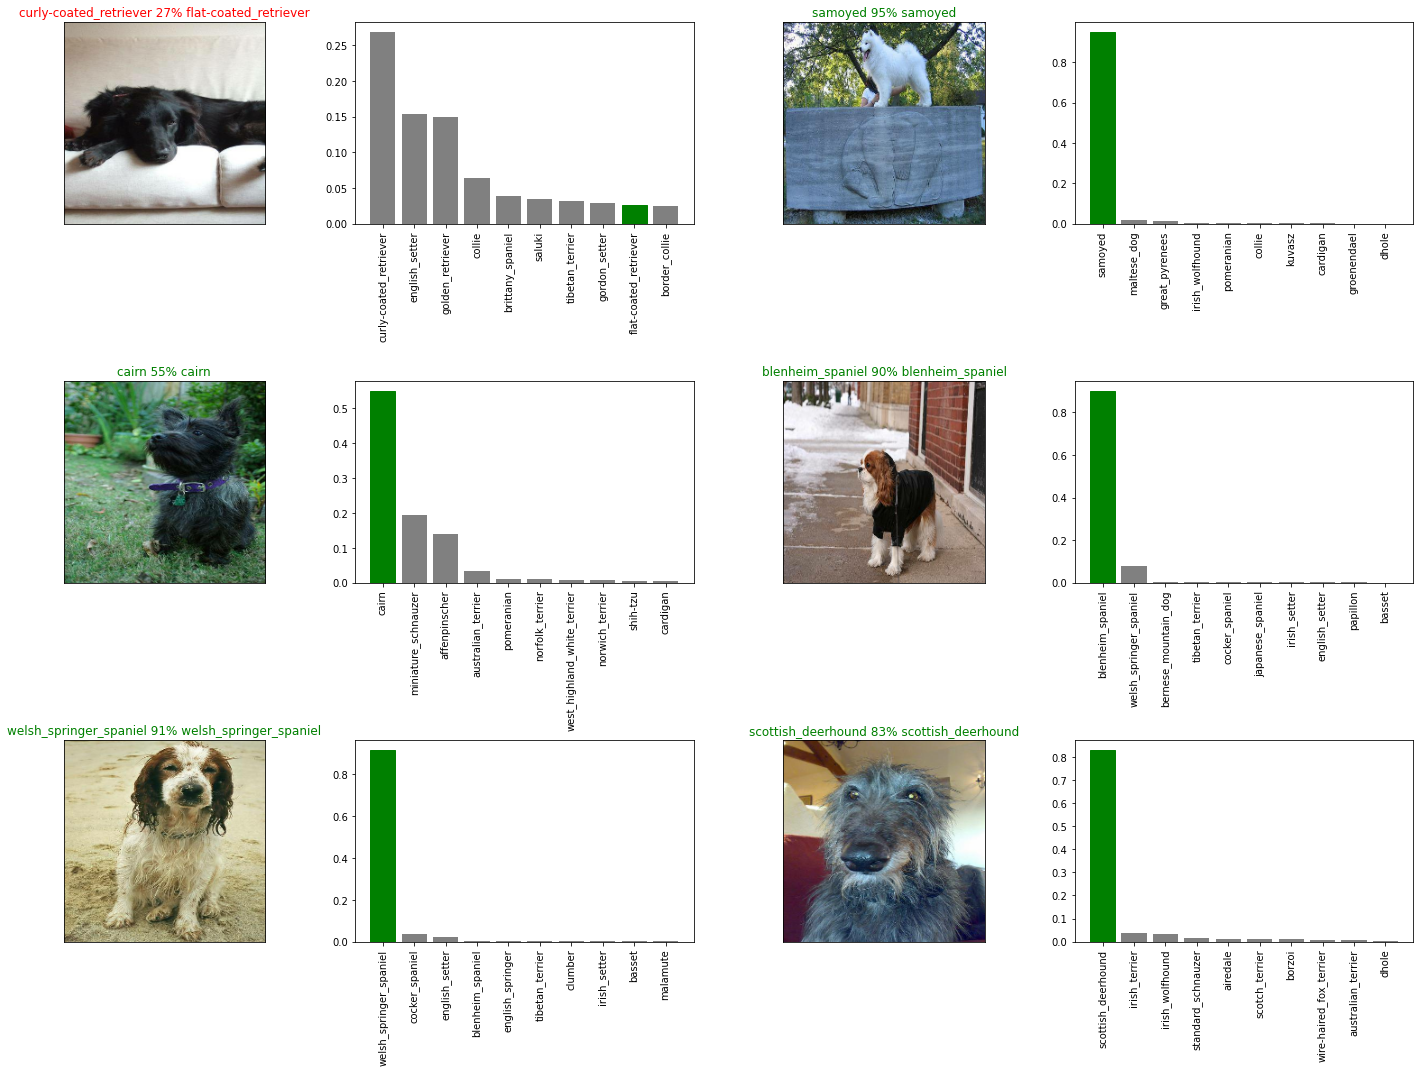

In [61]:
# Checking out a few predictions and their different values
i_mulit = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols

plt.figure(figsize = (10* num_cols, 5 * num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i + 1)
  plot_prediction(prediction_prob = predictions, labels = val_labels, images = val_images, n = i + i_mulit)
  plt.subplot(num_rows, 2 * num_cols, 2*i+2)
  plot_10_prediction(prediction_probabilites=predictions, labels = val_labels, n = i + i_mulit)
  plt.tight_layout()

plt.tight_layout(h_pad = 1.0)  
plt.show()

## Saving and Reloading a Trained Model

In [0]:
# Function to save model
def save_model(model, suffix = None):
  """
  Saves given model in a models folder and appends suffix (string)
  """
  
  # Create model folder pathname with current time
  modeldir = os.path.join('drive/My Drive/dog-spotter/models', datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + '-' + suffix + '.h5' # save model format
  print(f'Saving model to {model_path}') 
  model.save(model_path)
  return model_path

In [0]:
# Function to load model
def load_model(model_path):
  """
  Loads saved model from the given path
  """
  print(f'Loading saved model from {model_path}')
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects = {'KerasLayer': hub.KerasLayer})
  
  return model

In [64]:
# Save model trained on 1000 images
save_model(model, suffix = '1000-images-mobilenetV2-Adam')

Saving model to drive/My Drive/dog-spotter/models/20200509-05391589002796-1000-images-mobilenetV2-Adam.h5


'drive/My Drive/dog-spotter/models/20200509-05391589002796-1000-images-mobilenetV2-Adam.h5'

In [65]:
# load model
load_1000_image_model = load_model('drive/My Drive/dog-spotter/models/20200508-23151588979757-1000-images-mobilenetV2-Adam.h5')

Loading saved model from drive/My Drive/dog-spotter/models/20200508-23151588979757-1000-images-mobilenetV2-Adam.h5


In [66]:
# Evaluate the pre-saved model
model.evaluate(valid_data)

7/7 [==============================] - 1s 112ms/step - loss: 1.1440 - accuracy: 0.7000


[1.143965482711792, 0.699999988079071]

In [67]:
# Evaluate loaded model
load_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 1s 118ms/step - loss: 1.2791 - accuracy: 0.6550


[1.2790669202804565, 0.6549999713897705]

## Training Model on the Full Dataset

In [68]:
len(X), len(y)

(10222, 10222)

In [69]:
full_data = create_data_batches(X, y)

Creating training data batches...


In [70]:
# Create model for full dataset
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# Since no validation set while looking over full dataset, we can't monitor validation accuracy
full_model_early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 3)

Since we're fitting the model on the entire dataset, this will take a long time to run ~ 1 hour +

In [72]:
# Fit full model to entire data set
full_model.fit(x = full_data, 
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stop])

Epoch 1/100
  2/320 [..............................] - ETA: 1:44 - loss: 6.0745 - accuracy: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.283020). Check your callbacks.


320/320 [==============================] - 57s 178ms/step - loss: 1.3752 - accuracy: 0.6638
Epoch 2/100
320/320 [==============================] - 57s 179ms/step - loss: 0.4059 - accuracy: 0.8800
Epoch 3/100
320/320 [==============================] - 57s 179ms/step - loss: 0.2383 - accuracy: 0.9342
Epoch 4/100
320/320 [==============================] - 58s 181ms/step - loss: 0.1548 - accuracy: 0.9631
Epoch 5/100
320/320 [==============================] - 56s 176ms/step - loss: 0.1061 - accuracy: 0.9787
Epoch 6/100
320/320 [==============================] - 57s 177ms/step - loss: 0.0780 - accuracy: 0.9873
Epoch 7/100
320/320 [==============================] - 56s 176ms/step - loss: 0.0580 - accuracy: 0.9919
Epoch 8/100
320/320 [==============================] - 56s 176ms/step - loss: 0.0459 - accuracy: 0.9942
Epoch 9/100
320/320 [==============================] - 57s 179ms/step - loss: 0.0383 - accuracy: 0.9956
Epoch 10/100
320/320 [==============================] - 57s 178ms/step - los

In [73]:
save_model(full_model, suffix = 'full-imageset-mobilenetV2-Adam')

Saving model to drive/My Drive/dog-spotter/models/20200509-05581589003894-full-imageset-mobilenetV2-Adam.h5


'drive/My Drive/dog-spotter/models/20200509-05581589003894-full-imageset-mobilenetV2-Adam.h5'

In [74]:
# load full model
loaded_full_model = load_model('drive/My Drive/dog-spotter/models/20200509-02571588993022-full-imageset-mobilenetV2-Adam.h5')

Loading saved model from drive/My Drive/dog-spotter/models/20200509-02571588993022-full-imageset-mobilenetV2-Adam.h5


In [75]:
len(X)

10222

## Test Dataset Predictions

In [0]:
# Load test dataset filenames
test_path = "drive/My Drive/dog-spotter/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

In [77]:
len(test_filenames)

10357

In [78]:
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches...


In [79]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

This will take a long time to run ~ 1 hour +

In [80]:
test_predictions = loaded_full_model.predict(test_data, verbose = 1)

324/324 [==============================] - 55s 170ms/step


In [0]:
# Saves predictions (Numpy Array) to csv file
np.savetxt('drive/My Drive/dog-spotter/prediction-array.csv', test_predictions, delimiter = ',')

In [0]:
test_predictions = np.loadtxt('drive/My Drive/dog-spotter/prediction-array.csv', delimiter = ',')

In [83]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for submission

Evaluation format can be found on the kaggle website: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

But the evaluation format will be: 
* a Pandas dataframe with an ID column along with columns for each dog breed 
* extracting test image ID from test data set
* each dog breed column will have a prediction probability
* export dataframe as CSV

In [0]:
# Create pandas dataframe
preds_df = pd.DataFrame(columns = ['id'] + list(unique_breeds))

In [0]:
# Append test image id
preds_df['id'] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [87]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,f155d5fe889d139892c1d7d46804f419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ed0ec7befaa38726a118ab7e4d53b332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f237c237633a38bd52c2b1de238e945e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f0ee3d22666302ec27338aa29f34c72f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f054f5578e5c9d3f6759b357df3c5f16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Add prediction probabilities for each dog breed column
preds_df[list(unique_breeds)] = test_predictions

In [89]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,f155d5fe889d139892c1d7d46804f419,6.1147e-10,4.69386e-10,5.74348e-08,2.20448e-10,0.000165192,8.7445e-10,9.53807e-08,3.36381e-08,1.20995e-09,5.05702e-12,3.43988e-07,2.56997e-13,1.578e-08,2.15628e-10,7.6854e-11,5.22126e-09,4.87167e-11,1.87786e-09,1.20469e-11,3.08115e-10,7.75938e-12,5.32939e-12,2.83497e-11,5.20873e-11,1.75582e-10,5.89078e-13,1.68483e-12,1.9644e-11,3.49561e-06,2.46769e-06,1.50491e-10,2.95732e-11,9.51181e-13,1.12197e-07,2.286e-05,1.91634e-11,9.20531e-11,5.94359e-08,1.68143e-06,...,3.07651e-06,3.17299e-11,1.72283e-13,2.13257e-12,1.40805e-06,5.34605e-12,3.4054e-11,4.4587e-10,6.21647e-09,1.0419e-06,2.68333e-10,1.47517e-10,3.13401e-13,1.78598e-10,1.27855e-11,6.35651e-07,7.75548e-10,1.03948e-07,2.35374e-10,5.34796e-13,8.94511e-10,4.34998e-10,8.599e-08,7.71967e-07,2.27496e-07,8.51439e-08,6.07096e-10,4.35194e-12,8.9272e-14,4.1377e-12,7.38693e-07,1.08753e-07,4.13628e-09,1.80094e-09,8.12351e-05,1.48055e-12,2.52811e-09,1.07269e-05,2.09546e-10,7.75209e-10
1,ed0ec7befaa38726a118ab7e4d53b332,1.77989e-12,3.35303e-12,2.61044e-12,5.92799e-05,1.32967e-11,4.81122e-11,1.11389e-09,1.26439e-09,8.3413e-12,1.18261e-10,3.2274e-09,1.96724e-11,1.98704e-13,8.81564e-11,2.68223e-13,6.1001e-13,3.4373e-12,1.19078e-08,2.77118e-10,8.94573e-14,2.2441e-13,4.43625e-14,1.59977e-12,1.06871e-12,1.1218e-10,1.35304e-11,5.57328e-12,2.78321e-11,3.45327e-11,1.58993e-11,1.76341e-12,8.91238e-14,2.43101e-13,8.39546e-09,2.04499e-11,2.22409e-10,2.46196e-10,2.01126e-10,3.07337e-12,...,3.03884e-13,8.39083e-09,4.63929e-10,7.92767e-10,7.61084e-11,7.63982e-12,7.76681e-08,3.97017e-13,5.34715e-13,2.73113e-12,5.53098e-12,7.27919e-14,3.25321e-13,9.09627e-15,3.6024e-13,2.65876e-10,1.01402e-10,1.43279e-08,2.78653e-10,6.24757e-13,4.38977e-11,6.99e-13,1.43527e-10,8.26463e-09,4.59436e-10,2.77775e-11,1.53323e-07,1.08507e-12,2.06081e-14,1.3273e-12,6.31393e-11,7.90818e-11,2.50716e-10,5.54908e-09,1.68375e-13,6.77138e-10,3.92443e-11,5.11343e-10,0.9909,3.65997e-09
2,f237c237633a38bd52c2b1de238e945e,0.00185493,1.11885e-06,4.33288e-09,1.3271e-08,7.11107e-13,5.20854e-13,9.59897e-10,5.96473e-10,1.80891e-12,1.27961e-13,9.7776e-09,4.56928e-07,4.82937e-10,2.93852e-07,2.04173e-10,8.29277e-08,9.71604e-11,7.3717e-08,3.07559e-10,1.54565e-09,0.00176763,1.44125e-12,2.57459e-09,5.89895e-09,4.72424e-09,5.72925e-09,1.06898e-07,9.40657e-11,1.22865e-10,2.10406e-08,4.07693e-10,1.54689e-11,1.98831e-06,6.38291e-12,2.06818e-05,9.97676e-06,1.52777e-12,3.4296e-10,1.50494e-12,...,7.63929e-09,2.73344e-08,3.70781e-12,1.31052e-09,2.1162e-09,1.10201e-09,2.42232e-12,4.34374e-08,2.09963e-09,3.64547e-08,5.73127e-12,5.0587e-12,3.58457e-14,2.32082e-11,4.57929e-10,1.36297e-06,7.73852e-08,2.72899e-08,2.02708e-07,1.62445e-08,6.9628e-09,5.59624e-09,1.89802e-09,1.05647e-08,2.48498e-07,0.00572964,2.23865e-08,1.23508e-08,4.64673e-09,4.19477e-09,0.875702,2.27155e-09,6.81397e-08,6.65391e-09,8.54822e-10,3.10613e-12,4.18769e-10,2.88654e-1

In [0]:
# Save prediction dataframe to a csv
preds_df.to_csv('drive/My Drive/dog-spotter/full-model-prediction.csv', index = False)